In [11]:
import numpy
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import spdiags, diags
from tqdm import tqdm
import copy
# import copy
# from scipy.sparse import linalg
from scipy.linalg import solve_banded

Spatial variables

In [12]:
L_x=5; L_y=L_x
J=L_x*1;I=J
# D=[0.125,0.5] #Turing
D=[1,40] #schnakenberg maini2012


dx = float(L_x)/float(J-1); dy = float(L_y)/float(I-1)
x_grid = numpy.array([j*dx for j in range(J)]); y_grid = numpy.array([i*dy for i in range(I)])


Temporal variables

In [13]:
T = 10
N=T*10
dt = float(T)/float(N-1)
t_grid = numpy.array([n*dt for n in range(N)])

Define initial conditions and cell matrix



In [14]:
n_species=2
U0 = []
perturbation=0.001
steadystates=[0.1]*n_species
np.random.seed(1)

# cell_matrix = np.zeros(shape=(I,J))
# cell_matrix[int(I/2), int(J/2)] = 1
for index in range(n_species):
    U0.append(np.random.uniform(low=steadystates[index] - perturbation, high=steadystates[index] + perturbation, size=(I, J)))
# U0 = U0*cell_matrix



Define A tridiagonal matrix (left-hand side of Ax=b)

In [15]:
alpha = [D[n]*dt/(2.*dx*dx) for n in range(n_species)]

def A(alphan):
    bottomdiag = [-alphan for j in range(J-1)]
    centraldiag = [1.+alphan]+[1.+2.*alphan for j in range(J-2)]+[1.+alphan]
    topdiag = [-alphan for j in range(J-1)]
    diagonals = [bottomdiag,centraldiag,topdiag]
    A = diags(diagonals, [ -1, 0,1]).toarray()
    return A

def diagonal_form(a, upper = 1, lower= 1):
    """
    a is a numpy square matrix
    this function converts a square matrix to diagonal ordered form
    returned matrix in ab shape which can be used directly for scipy.linalg.solve_banded
    """
    n = a.shape[1]
    assert(np.all(a.shape ==(n,n)))

    ab = np.zeros((2*n-1, n))

    for i in range(n):
        ab[i,(n-1)-i:] = np.diagonal(a,(n-1)-i)

    for i in range(n-1):
        ab[(2*n-2)-i,:i+1] = np.diagonal(a,i-(n-1))

    mid_row_inx = int(ab.shape[0]/2)
    upper_rows = [mid_row_inx - i for i in range(1, upper+1)]
    upper_rows.reverse()
    upper_rows.append(mid_row_inx)
    lower_rows = [mid_row_inx + i for i in range(1, lower+1)]
    keep_rows = upper_rows+lower_rows
    ab = ab[keep_rows,:]


    return ab
ab_list = [diagonal_form(A(alphan)) for alphan in alpha]
alpha

[0.03232323232323232, 1.292929292929293]

Define b vector  (right-hand side of Ax=b)

In [16]:
def b(axis,ij,alphan,Un):
    b_t_stencil = np.array( [0] + [(1-alphan)] + [alphan])
    b_c_stencil = np.array( [alphan] + [(1-2*alphan)] + [alphan])
    b_b_stencil = np.array( [alphan] + [(1-alphan)] + [0])

    b = np.zeros(J)
    if axis == 'y':
        i = ij
        if i > 0 and i < I-1:
            for j in range(0,J):
                ux_three = [Un[j,i-1], Un[j,i], Un[j,i+1]]
                sub_b = np.sum(ux_three*b_c_stencil)
                b[j] = sub_b


        if i == 0:
            for j in range(0,J):
                ux_three = [0 , Un[j,i], Un[j,i+1]]
                sub_b = np.sum(ux_three*b_t_stencil)
                b[j] = sub_b

        if i == I-1:
            for j in range(0,J):
                ux_three = [Un[j,i-1], Un[j,i] , 0]
                sub_b = np.sum(ux_three*b_b_stencil)
                b[j] = sub_b

    if axis == 'x':
        j = ij
        if j > 0 and  j < J-1:
            for i in range(0,I):
                uy_three = [Un[j-1,i], Un[j,i], Un[j+1,i]]
                sub_b = np.sum(uy_three*b_c_stencil)
                b[i] = sub_b

        if j == 0:
            for i in range(0,I):
                uy_three = [0, Un[j,i], Un[j+1,i]]
                sub_b = np.sum(uy_three*b_t_stencil)
                b[i] = sub_b

        if j == J-1:
            for i in range(0,I):
                uy_three = [Un[j-1,i], Un[j,i], 0]
                sub_b = np.sum(uy_three*b_b_stencil)
                b[i] = sub_b

    return b

In [17]:
def turing(u):
    f_a = 5*u[0] - 6*u[1] + 1
    f_b = 6*u[0] - 7*u[1] + 1
    f_a = 0.5*u[0] - u[1] 
    f_b = 0.53125*u[0] - u[1] 
    return f_a, f_b

In [18]:
def schnakenberg(u,c=[0.1,1,0.9,1]): #schnakenberg maini2012
    c1,cm1,c2,c3 = c
    f_u0 = c1 - cm1*u[0] + c3*(u[0]**2)*u[1]
    f_u1 = c2 - c3*(u[0]**2)*u[1]
    return f_u0,f_u1
    

100%|██████████| 100/100 [00:00<00:00, 535.44it/s]


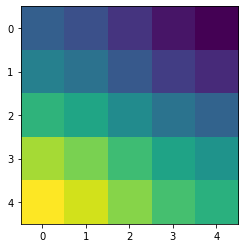

In [19]:
U = copy.deepcopy(U0)
U_record = []
for species_index in range(n_species):
    U_record.append(np.zeros([J, I, T])) #DO NOT SIMPLIFY TO U_record = [np.zeros([J, I, T])]*n_species


unittime=0
for ti in tqdm(range(N), disable = False):
    #First step: solve in y direction from n -> n+1/2
    U_half = copy.deepcopy(U)
#     f0 = turing(U)
    f0 = schnakenberg(U)

    for i in range(I):
        for n in range(n_species):
            U_half[n][:,i] = solve_banded((1, 1), ab_list[n], b('y',i,alpha[n],U[n]) +  f0[n][:,i]*(dt/2)) #CN step in one dimension to get banded(tridiagonal) A matrix

    #Second step: solve in x direction from n+1/2 -> n+1
    U_new = copy.deepcopy(U_half)
    f1 = schnakenberg(U_half)
    for j in range(J):
        for n in range(n_species):
            U_new[n][j,:] = solve_banded((1, 1), ab_list[n], b('x',j,alpha[n],U_half[n]) + f1[n][j,:]*(dt/2))


    hour = ti / (N / T)

    if hour % 1 == 0:  #only record at unit time (hour)
        #append results into top_array for records
        for species_index in range(n_species):
            U_record[species_index][:, :, int(hour)] = U_new[species_index] #issue in this line


    U = copy.deepcopy(U_new)

plt.imshow(U[0])


In [20]:
import pickle as pkl
pkl.dump( U, open( "schnakenberg.pkl", "wb" ) )


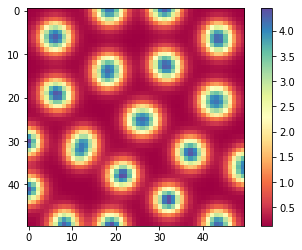

In [18]:
from matplotlib import cm

cmap = cm.Spectral
plt.imshow(U[0], cmap=cmap)
plt.colorbar()
plt.savefig("schnakenberg.png")